In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
import matplotlib.pyplot as plt
import torch

from torchdiffeq import odeint

from pideq.four_tanks import four_tanks
from pideq.net import PINN
from pideq.utils import load_from_wandb

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
net = load_from_wandb(PINN(), 'iwmrz7m6').to(device)
net.eval()

PINN(
  (fcn): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=4, bias=True)
    (11): ReLU()
  )
)

In [13]:
K = 200
dt = 1.
time = [dt * k for k in range(K+1)]

y0 = torch.Tensor([12.6, 13.0, 4.8, 4.9]).unsqueeze(0)

u = torch.Tensor([3.15, 3.15]).unsqueeze(0)
u

y = odeint(lambda t, y: four_tanks(y,u), y0, torch.Tensor([i * dt for i in range(K+1)]), method='rk4')
y = y.squeeze(1)
y.shape

torch.Size([201, 4])

In [17]:
y_pred = net(torch.Tensor(time).unsqueeze(-1).to(device))
y_pred.shape

torch.Size([201, 4])

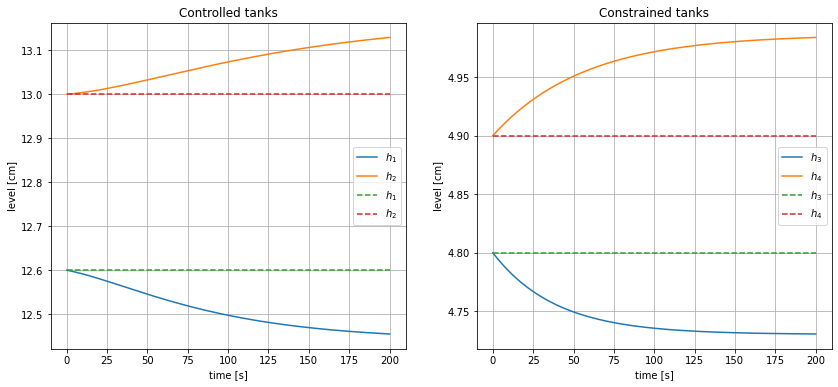

In [19]:
y_ = y.detach().numpy()
y_pred_ = y_pred.cpu().detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].set_title('Controlled tanks')
axs[0].plot(time, y_[:,0], label='$h_1$')
axs[0].plot(time, y_[:,1], label='$h_2$')
axs[0].plot(time, y_pred_[:,0], '--', label='$h_1$')
axs[0].plot(time, y_pred_[:,1], '--', label='$h_2$')
axs[0].set_ylabel('level [cm]')
axs[0].set_xlabel('time [s]')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Constrained tanks')
axs[1].plot(time, y_[:,2], label='$h_3$')
axs[1].plot(time, y_[:,3], label='$h_4$')
axs[1].plot(time, y_pred_[:,2], '--', label='$h_3$')
axs[1].plot(time, y_pred_[:,3], '--', label='$h_4$')
axs[1].set_ylabel('level [cm]')
axs[1].set_xlabel('time [s]')
axs[1].legend()
axs[1].grid()

plt.show()